Reference:
1. Breast Cancer Ultrasound: https://www.kaggle.com/datasets/aryashah2k/breast-ultrasound-images-dataset
2. UNet: https://github.com/MIC-DKFZ/basic_unet_example/tree/master/networks

In [100]:
from glob import glob
import numpy as np
import torch
from torch import nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
import cv2
import matplotlib.pyplot as plt
import random
import torch.nn.functional as F
import torchvision.transforms.functional as TF
from sklearn.metrics import f1_score
from sklearn.utils.class_weight import compute_class_weight
from PIL import Image

from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torch.optim import Optimizer
import adamod
from scipy.ndimage import map_coordinates
from scipy.ndimage import gaussian_filter

In [2]:
class UNet(nn.Module):
    def __init__(self, num_classes=3, in_channels=1, initial_filter_size=64, kernel_size=3, num_downs=4, norm_layer=nn.InstanceNorm2d):
        # norm_layer=nn.BatchNorm2d, use_dropout=False):
        super(UNet, self).__init__()

        # construct unet structure
        unet_block = UnetSkipConnectionBlock(in_channels=initial_filter_size * 2 ** (num_downs-1), out_channels=initial_filter_size * 2 ** num_downs,
                                             num_classes=num_classes, kernel_size=kernel_size, norm_layer=norm_layer, innermost=True)
        for i in range(1, num_downs):
            unet_block = UnetSkipConnectionBlock(in_channels=initial_filter_size * 2 ** (num_downs-(i+1)),
                                                 out_channels=initial_filter_size * 2 ** (num_downs-i),
                                                 num_classes=num_classes, kernel_size=kernel_size, submodule=unet_block, norm_layer=norm_layer)
        unet_block = UnetSkipConnectionBlock(in_channels=in_channels, out_channels=initial_filter_size,
                                             num_classes=num_classes, kernel_size=kernel_size, submodule=unet_block, norm_layer=norm_layer,
                                             outermost=True)

        self.model = unet_block

    def forward(self, x):
        return self.model(x)


# Defines the submodule with skip connection.
# X -------------------identity---------------------- X
#   |-- downsampling -- |submodule| -- upsampling --|
class UnetSkipConnectionBlock(nn.Module):
    def __init__(self, in_channels=None, out_channels=None, num_classes=1, kernel_size=3,
                 submodule=None, outermost=False, innermost=False, norm_layer=nn.InstanceNorm2d, use_dropout=False):
        super(UnetSkipConnectionBlock, self).__init__()
        self.outermost = outermost
        # downconv
        pool = nn.MaxPool2d(2, stride=2)
        conv1 = self.contract(in_channels=in_channels, out_channels=out_channels, kernel_size=kernel_size, norm_layer=norm_layer)
        conv2 = self.contract(in_channels=out_channels, out_channels=out_channels, kernel_size=kernel_size, norm_layer=norm_layer)

        # upconv
        conv3 = self.expand(in_channels=out_channels*2, out_channels=out_channels, kernel_size=kernel_size)
        conv4 = self.expand(in_channels=out_channels, out_channels=out_channels, kernel_size=kernel_size)

        if outermost:
            final = nn.Conv2d(out_channels, num_classes, kernel_size=1)
            down = [conv1, conv2]
            up = [conv3, conv4, final]
            model = down + [submodule] + up
        elif innermost:
            upconv = nn.ConvTranspose2d(in_channels*2, in_channels,
                                        kernel_size=2, stride=2)
            model = [pool, conv1, conv2, upconv]
        else:
            upconv = nn.ConvTranspose2d(in_channels*2, in_channels, kernel_size=2, stride=2)

            down = [pool, conv1, conv2]
            up = [conv3, conv4, upconv]

            if use_dropout:
                model = down + [submodule] + up + [nn.Dropout(0.5)]
            else:
                model = down + [submodule] + up

        self.model = nn.Sequential(*model)

    @staticmethod
    def contract(in_channels, out_channels, kernel_size=3, norm_layer=nn.InstanceNorm2d):
        layer = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size, padding=1),
            norm_layer(out_channels),
            nn.LeakyReLU(inplace=True))
        return layer

    @staticmethod
    def expand(in_channels, out_channels, kernel_size=3):
        layer = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size, padding=1),
            nn.LeakyReLU(inplace=True),
        )
        return layer

    @staticmethod
    def center_crop(layer, target_width, target_height):
        batch_size, n_channels, layer_width, layer_height = layer.size()
        xy1 = (layer_width - target_width) // 2
        xy2 = (layer_height - target_height) // 2
        return layer[:, :, xy1:(xy1 + target_width), xy2:(xy2 + target_height)]

    def forward(self, x):
        if self.outermost:
            return self.model(x)
        else:
            crop = self.center_crop(self.model(x), x.size()[2], x.size()[3])
            return torch.cat([x, crop], 1)

In [3]:
paths = glob('data/*/*')

print(f"'normal' class has {len([i for i in paths if 'normal' in i and 'mask' not in i])} images and {len([i for i in paths if 'normal' in i and 'mask' in i])} masks.")
print(f"'benign' class has {len([i for i in paths if 'benign' in i and 'mask' not in i])} images and {len([i for i in paths if 'benign' in i and 'mask' in i])} masks.")
print(f"'malignant' class has {len([i for i in paths if 'malignant' in i and 'mask' not in i])} images and {len([i for i in paths if 'malignant' in i and 'mask' in i])} masks.")
print(f"\nThere are total of {len([i for i in paths if 'mask' not in i])} images and {len([i for i in paths if 'mask' in i])} masks.")

'normal' class has 133 images and 133 masks.
'benign' class has 437 images and 454 masks.
'malignant' class has 210 images and 211 masks.

There are total of 780 images and 798 masks.


In [4]:
size = 128 # set ultrasound image size as 128x128

def load_image(path, size):
    image = cv2.imread(path)
    image = cv2.resize(image, (size,size))
    image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)   # shape: (size,size,3) -> (size,size,1)
    image = image/255.   # normalize
    return image

In [5]:
import pandas as pd
df = pd.DataFrame(glob('data/*/*'))
df = df.rename(columns={0: 'file_path'})

df[['folder', 'class','study_id']] = df['file_path'].str.split('/', expand=True)
df.loc[~df['study_id'].str.contains('_mask'), 'study_id'] = df['study_id'].str.replace('.png', '')
df.loc[~df['study_id'].str.contains('_mask'), 'study_id'] += '_image.png'
df.loc[df['study_id'].str.contains('_mask'), 'data_type'] = "mask"
df.loc[~df['study_id'].str.contains('_mask'), 'data_type'] = "image"
df.loc[df['class'].str.contains('normal'), 'class_id'] = 0
df.loc[df['class'].str.contains('benign'), 'class_id'] = 1
df.loc[df['class'].str.contains('malignant'), 'class_id'] = 2
df['class_id'] = df['class_id'].astype(int)
df.loc[df['study_id'].str.contains('_mask'), 'study_id'] = df['study_id'].str.replace('_mask', '')
df.loc[~df['study_id'].str.contains('_mask'), 'study_id'] = df['study_id'].str.replace('_image', '')
df.loc[df['study_id'].str.contains('.png'), 'study_id'] = df['study_id'].str.replace('.png', '')
df['study_id'] = df['study_id'].str.replace(f'(', '_').str.replace(f')', '').str.replace(f' ', '')
df[['class', 'instance_id','instance_sub_id']] = df['study_id'].str.split('_', expand=True)
df['instance_sub_id'] = df['instance_sub_id'].fillna(0)
df['new_study_id'] = df['class'] + "_" + df['instance_id'].astype(str)

image_df = df[df['data_type']=="image"]
mask_df = df[df['data_type']=="mask"]

merged_df = pd.merge(mask_df, image_df[['file_path', 'new_study_id']], how='left', on='new_study_id')
columns_to_drop = ['data_type', 'folder','study_id']
merged_df = merged_df.drop(columns_to_drop, axis=1)
merged_df = merged_df.rename(columns={'file_path_x': 'mask_path'})
merged_df = merged_df.rename(columns={'file_path_y': 'image_path'})
merged_df = merged_df.rename(columns={'new_study_id': 'study_id'})
# Specify the desired column order
new_order = ['image_path', 'mask_path', 'study_id','class','class_id','instance_id','instance_sub_id']
# Reorder the columns
merged_df = merged_df[new_order]

instance_count = merged_df.groupby('image_path').count()
instance_count = instance_count.reset_index()[['image_path','instance_sub_id']]
instance_count = instance_count.rename(columns={'instance_sub_id': 'max_count'})
merged_df = pd.merge(merged_df, instance_count, how='left', on='image_path')
merged_df = merged_df.sort_values(['mask_path','instance_id']).reset_index(drop=True)
merged_df

image_path                            mask_path  \
0      data/benign/benign (1).png      data/benign/benign (1)_mask.png   
1     data/benign/benign (10).png     data/benign/benign (10)_mask.png   
2    data/benign/benign (100).png    data/benign/benign (100)_mask.png   
3    data/benign/benign (100).png  data/benign/benign (100)_mask_1.png   
4    data/benign/benign (101).png    data/benign/benign (101)_mask.png   
..                            ...                                  ...   
793   data/normal/normal (95).png     data/normal/normal (95)_mask.png   
794   data/normal/normal (96).png     data/normal/normal (96)_mask.png   
795   data/normal/normal (97).png     data/normal/normal (97)_mask.png   
796   data/normal/normal (98).png     data/normal/normal (98)_mask.png   
797   data/normal/normal (99).png     data/normal/normal (99)_mask.png   

       study_id   class  class_id instance_id instance_sub_id  max_count  
0      benign_1  benign         1           1               0          1  
1     benign_10  benign         1          10               0          1  
2    benign_100  benign         1         100               0          2  
3    benign_100  benign         1         100               1          2  
4    benign_101  benign         1         101               0          1  
..          ...     ...       ...         ...             ...        ...  
793   normal_95  normal         0          95               0          1  
794   normal_96  normal         0          96               0          1  
795   normal_97  normal         0          97               0          1  
796   normal_98  normal         0          98               0          1  
797   normal_99  normal         0          99               0          1  

[798 rows x 8 columns]

In [6]:
normal_df = merged_df[merged_df['class']=="normal"]
malignant_df = merged_df[merged_df['class']=="malignant"]
benign_df = merged_df[merged_df['class']=="benign"]

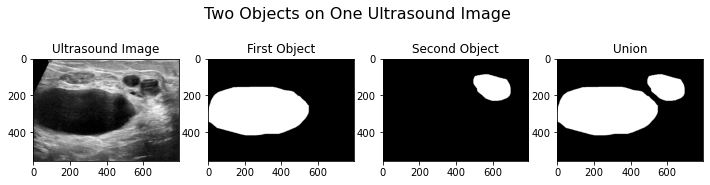

In [7]:
fig, ax = plt.subplots(1,4, figsize=(12,3))

img_sample0 = cv2.imread("data/benign/benign (98).png")
img_sample1 = cv2.imread("data/benign/benign (98)_mask_1.png")
img_sample2 = cv2.imread("data/benign/benign (98)_mask.png")
image_sample_1_2 = img_sample1+img_sample2

ax[0].imshow(img_sample0, cmap='gray')
ax[0].set_title('Ultrasound Image')
ax[1].imshow(img_sample1, cmap='gray')
ax[1].set_title('First Object')
ax[2].imshow(img_sample2, cmap='gray')
ax[2].set_title('Second Object')
ax[3].imshow(image_sample_1_2, cmap='gray')
ax[3].set_title('Union')
fig.suptitle('Two Objects on One Ultrasound Image', fontsize=16)
plt.show()

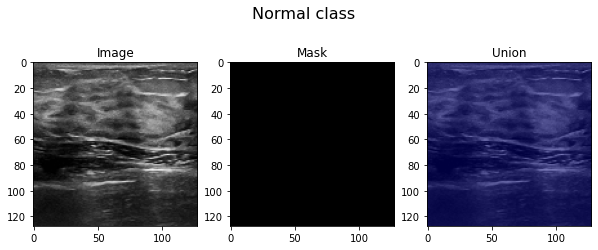

In [8]:
fig, ax = plt.subplots(1,3, figsize=(10,4))

i = random.choice(list(range(normal_df.shape[0])))
X = load_image(normal_df.iloc[i]['image_path'],size)
y = load_image(normal_df.iloc[i]['mask_path'],size)

ax[0].imshow(X, cmap='gray')
ax[0].set_title('Image')
ax[1].imshow(y, cmap='gray')
ax[1].set_title('Mask')
ax[2].imshow(X, cmap='gray')
ax[2].imshow(torch.squeeze(torch.from_numpy(y)), alpha=0.5, cmap='jet')
ax[2].set_title('Union')
fig.suptitle('Normal class', fontsize=16)
plt.show()

In [9]:
fig, ax = plt.subplots(1,3, figsize=(10,4))

i = random.choice(list(range(benign_df.shape[0])))
X = load_image(benign_df.iloc[i]['image_path'],size)
y = load_image(benign_df.iloc[i]['mask_path'],size)

ax[0].imshow(X, cmap='gray')
ax[0].set_title('Image')
ax[1].imshow(y, cmap='gray')
ax[1].set_title('Mask')
ax[2].imshow(X, cmap='gray')
ax[2].imshow(torch.squeeze(torch.from_numpy(y)), alpha=0.5, cmap='jet')
ax[2].set_title('Union')
fig.suptitle('Benign class', fontsize=16)
plt.show()

In [10]:
fig, ax = plt.subplots(1,3, figsize=(10,4))

i = random.choice(list(range(malignant_df.shape[0])))

X = load_image(malignant_df.iloc[i]['image_path'],size)
y = load_image(malignant_df.iloc[i]['mask_path'],size)

ax[0].imshow(X, cmap='gray')
ax[0].set_title('Image')
ax[1].imshow(y, cmap='gray')
ax[1].set_title('Mask')
ax[2].imshow(X, cmap='gray')
ax[2].imshow(torch.squeeze(torch.from_numpy(y)), alpha=0.5, cmap='jet')
ax[2].set_title('Union')
fig.suptitle('Malignant class', fontsize=16)
plt.show()

In [11]:
y_normal = []

for index, row in normal_df.iterrows():
    y_normal.append(load_image(row['mask_path'],size))
    
y_benign = []

for index, row in benign_df.iterrows():
    y_benign.append(load_image(row['mask_path'],size))
    
y_malignant = []

for index, row in malignant_df.iterrows():
    y_malignant.append(load_image(row['mask_path'],size))

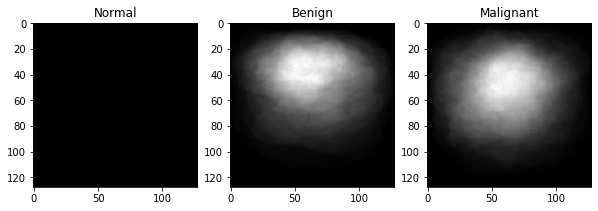

In [12]:
fig, ax = plt.subplots(1,3, figsize=(10,4))

ax[0].imshow(sum(y_normal), cmap='gray')
ax[0].set_title('Normal')
ax[1].imshow(sum(y_benign), cmap='gray')
ax[1].set_title('Benign')
ax[2].imshow(sum(y_malignant), cmap='gray')
ax[2].set_title('Malignant')
plt.show()

In [13]:
idx_to_class = {0: 'normal',
                1: 'benign',
                2: 'malignant'}
idx_to_class

{0: 'normal', 1: 'benign', 2: 'malignant'}

In [14]:
group_terms = ['image_path','study_id','class','class_id','instance_id','max_count']
feed_df = merged_df.groupby(group_terms).apply(lambda x: pd.Series({
    'mask_path': ','.join(x['mask_path']),
    'instance_sub_id': ','.join(x['instance_sub_id'].astype(str))
})).reset_index()

feed_df

image_path    study_id   class  class_id instance_id  \
0      data/benign/benign (1).png    benign_1  benign         1           1   
1     data/benign/benign (10).png   benign_10  benign         1          10   
2    data/benign/benign (100).png  benign_100  benign         1         100   
3    data/benign/benign (101).png  benign_101  benign         1         101   
4    data/benign/benign (102).png  benign_102  benign         1         102   
..                            ...         ...     ...       ...         ...   
775   data/normal/normal (95).png   normal_95  normal         0          95   
776   data/normal/normal (96).png   normal_96  normal         0          96   
777   data/normal/normal (97).png   normal_97  normal         0          97   
778   data/normal/normal (98).png   normal_98  normal         0          98   
779   data/normal/normal (99).png   normal_99  normal         0          99   

     max_count                                          mask_path  \
0            1                    data/benign/benign (1)_mask.png   
1            1                   data/benign/benign (10)_mask.png   
2            2  data/benign/benign (100)_mask.png,data/benign/...   
3            1                  data/benign/benign (101)_mask.png   
4            1                  data/benign/benign (102)_mask.png   
..         ...                                                ...   
775          1                   data/normal/normal (95)_mask.png   
776          1                   data/normal/normal (96)_mask.png   
777          1                   data/normal/normal (97)_mask.png   
778          1                   data/normal/normal (98)_mask.png   
779          1                   data/normal/normal (99)_mask.png   

    instance_sub_id  
0                 0  
1                 0  
2               0,1  
3                 0  
4                 0  
..              ...  
775               0  
776               0  
777               0  
778               0  
779               0  

[780 rows x 8 columns]

In [15]:
images = []
masks = []
for index, row in feed_df[feed_df['max_count']>2].iterrows():
    
    image = load_image(row['image_path'],128)
    images.append(image)
    combined_mask = []
    for data in row['mask_path'].split(','):
        mask = load_image(data,128)
        combined_mask.append(mask)
        
    combined_mask = np.sum(combined_mask,axis=0).astype(int)
    masks.append(combined_mask)

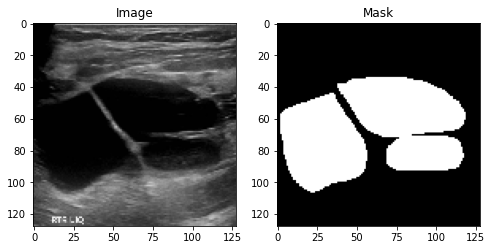

In [16]:
fig, ax = plt.subplots(1,2, figsize=(8,4))

ax[0].imshow(image, cmap='gray')
ax[0].set_title('Image')
ax[1].imshow(combined_mask, cmap='gray')
ax[1].set_title('Mask')

plt.show()

In [112]:
class ultrasound_data(Dataset):
    def __init__(self, df, transform = None, double_transform = None):
        
        self.img_path = df.iloc[:,0].tolist() # image file path at location 2 of a dataframe
        self.label_path = df.iloc[:,6].tolist() # image label at location 2 of a dataframe
        self.max_count = df.iloc[:,5].tolist() # how many labels are associated with one image
        self.transform = transform
        self.transform2 = double_transform
        
        if self.transform == None:
            self.transform = transforms.Compose([
                transforms.Resize((128,128)),
                transforms.ToTensor(),
            ])

    def __len__(self):
        return len(self.img_path)
    
    def __getitem__(self, index):

        if self.max_count[index] == 1:
            image_name = self.img_path[index]       
            image = self.transform(Image.open(image_name).convert('L'))
            label_name = self.label_path[index]
            label = self.transform(Image.open(label_name).convert('L'))
            label = torch.where(label == 0, torch.tensor(0), torch.tensor(1)).to(torch.int)

        else:
            image_name = self.img_path[index]
            image = self.transform(Image.open(image_name).convert('L'))            
            label_name = self.label_path[index]
            
            labels = []
            for label_path in label_name.split(','):
                one_label = self.transform(Image.open(label_path).convert('L'))
                labels.append(np.array(one_label))

            label = torch.from_numpy(np.sum(labels,axis=0)).to(torch.int)
            label = torch.where(label == 0, torch.tensor(0), torch.tensor(1)).to(torch.int)
        
        if self.transform2 != None:
            image, label = self.transform2(image, label)

        return image, label

In [113]:
ultrasound_df = ultrasound_data(feed_df)

In [114]:
feed_df

image_path    study_id   class  class_id instance_id  \
0      data/benign/benign (1).png    benign_1  benign         1           1   
1     data/benign/benign (10).png   benign_10  benign         1          10   
2    data/benign/benign (100).png  benign_100  benign         1         100   
3    data/benign/benign (101).png  benign_101  benign         1         101   
4    data/benign/benign (102).png  benign_102  benign         1         102   
..                            ...         ...     ...       ...         ...   
775   data/normal/normal (95).png   normal_95  normal         0          95   
776   data/normal/normal (96).png   normal_96  normal         0          96   
777   data/normal/normal (97).png   normal_97  normal         0          97   
778   data/normal/normal (98).png   normal_98  normal         0          98   
779   data/normal/normal (99).png   normal_99  normal         0          99   

     max_count                                          mask_path  \
0            1                    data/benign/benign (1)_mask.png   
1            1                   data/benign/benign (10)_mask.png   
2            2  data/benign/benign (100)_mask.png,data/benign/...   
3            1                  data/benign/benign (101)_mask.png   
4            1                  data/benign/benign (102)_mask.png   
..         ...                                                ...   
775          1                   data/normal/normal (95)_mask.png   
776          1                   data/normal/normal (96)_mask.png   
777          1                   data/normal/normal (97)_mask.png   
778          1                   data/normal/normal (98)_mask.png   
779          1                   data/normal/normal (99)_mask.png   

    instance_sub_id  
0                 0  
1                 0  
2               0,1  
3                 0  
4                 0  
..              ...  
775               0  
776               0  
777               0  
778               0  
779               0  

[780 rows x 8 columns]

In [115]:
max_seed = ((2**32 - 1))
np.random.seed(0)
seed_base = np.random.randint(max_seed, size = 5)

In [116]:
experiment_id = 1

def set_seeds(seed=seed_base[experiment_id], experiment_id=experiment_id):
    if not seed:
        seed = 10
        
    seed = int(seed * experiment_id)

    print("[ Using Seed : ", seed, " ]")

    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.cuda.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    
set_seeds()

[ Using Seed :  2546248239  ]


class Config:
    """
    Holds configuration parameters
    """
    def __init__(self):
        self.name = "basic_unet_"+"seed"+str(experiment_id)
        self.root_dir = r"../../data"
        self.n_epochs = 100 # 10
        self.learning_rate = 0.0002
        self.batch_size = 64
        self.patch_size = 64 #64
        self.test_results_dir = r"out"

In [117]:
split_idx = np.arange((len(ultrasound_df)))

# 60:20:20 split using train_test_split()
train, test = train_test_split(split_idx, test_size=0.2, shuffle=True, stratify=feed_df['class'])
train, val = train_test_split(train, test_size=0.25, shuffle=True)

print("Train Size:", len(train), "; Validation Size:", len(val), "; Test Size:", len(test))    
split=dict({'train': np.array(train),
            'val': np.array(val),
            'test': np.array(test)}
          )

Train Size: 468 ; Validation Size: 156 ; Test Size: 156


In [118]:
# Do we have CUDA available?
if not torch.cuda.is_available():
    print("WARNING: No CUDA device is found. This may take significantly longer!")
else:
    print("GPU Status:",torch.cuda.is_available())

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

GPU Status: True


In [136]:
# Reference: https://github.com/hayashimasa/UNet-PyTorch/blob/main/augmentation.py
class DoubleHorizontalFlip:
    """Apply horizontal flips to both image and segmentation mask."""

    def __init__(self, p=0.5):
        self.p = p

    def __call__(self, image, mask, weight=None):
        p = random.random()
        if p < self.p:
            image = TF.hflip(image)
            mask = TF.hflip(mask)
        if weight is None:
            return image, mask
        elif p > self.p:
            weight = TF.hflip(weight)
        return image, mask, weight

    def __repr__(self):
        return self.__class__.__name__ + f'(p={self.p})' 

class DoubleVerticalFlip:
    """Apply horizontal flips to both image and segmentation mask."""

    def __init__(self, p=0.5):
        self.p = p

    def __call__(self, image, mask, weight=None):
        p = random.random()
        if p < self.p:
            image = TF.vflip(image)
            mask = TF.vflip(mask)
        if weight is None:
            return image, mask
        elif p > self.p:
            weight = TF.hflip(weight)
        return image, mask, weight

    def __repr__(self):
        return self.__class__.__name__ + f'(p={self.p})' 
    
class DoubleElasticTransform:
    """Based on implimentation on
    https://gist.github.com/erniejunior/601cdf56d2b424757de5"""

    def __init__(self, alpha=250, sigma=10, p=0.5, seed=None, randinit=True):
        if not seed:
            seed = random.randint(1, 100)
        self.random_state = np.random.RandomState(seed)
        self.alpha = alpha
        self.sigma = sigma
        self.p = p
        self.randinit = randinit

    def __call__(self, image, mask, weight=None):
        if random.random() < self.p:
            if self.randinit:
                seed = random.randint(1, 100)
                self.random_state = np.random.RandomState(seed)
                self.alpha = random.uniform(100, 300)
                self.sigma = random.uniform(10, 15)
                # print(self.alpha)
                # print(self.sigma)

            dim = image.shape
            dx = self.alpha * gaussian_filter(
                (self.random_state.rand(*dim[1:]) * 2 - 1),
                self.sigma,
                mode="constant",
                cval=0
            )
            dy = self.alpha * gaussian_filter(
                (self.random_state.rand(*dim[1:]) * 2 - 1),
                self.sigma,
                mode="constant",
                cval=0
            )
            image = image.view(*dim[1:]).numpy()
            mask = mask.view(*dim[1:]).numpy()
            x, y = np.meshgrid(np.arange(dim[1]), np.arange(dim[2]))
            indices = np.reshape(y+dy, (-1, 1)), np.reshape(x+dx, (-1, 1))
            image = map_coordinates(image, indices, order=1)
            mask = map_coordinates(mask, indices, order=1)
            image, mask = image.reshape(dim), mask.reshape(dim)
            image, mask = torch.Tensor(image), torch.Tensor(mask)
            if weight is None:
                return image, mask
            weight = weight.view(*dim[1:]).numpy()
            weight = map_coordinates(weight, indices, order=1)
            weight = weight.reshape(dim)
            weight = torch.Tensor(weight)

        return (image, mask) if weight is None else (image, mask, weight)

class DoubleCompose(transforms.Compose):

    def __call__(self, image, mask, weight=None):
        if weight is None:
            for t in self.transforms:
                image, mask = t(image, mask)
            return image, mask
        for t in self.transforms:
            image, mask, weight = t(image, mask, weight)
        return image, mask, weight

In [137]:
train_transform = DoubleCompose([
    DoubleElasticTransform(),
    DoubleHorizontalFlip(p = 0.25),
    DoubleVerticalFlip(p = 0.25),
])

valid_transform = DoubleCompose([
    DoubleHorizontalFlip(p = 0.25),
    DoubleVerticalFlip(p = 0.25),
])

In [138]:
np.unique(feed_df.iloc[split["train"]]['class'],return_counts=True)

(array(['benign', 'malignant', 'normal'], dtype=object),
 array([267, 125,  76]))

In [139]:
np.unique(feed_df.iloc[split["val"]]['class'],return_counts=True)

(array(['benign', 'malignant', 'normal'], dtype=object), array([83, 43, 30]))

In [140]:
np.unique(feed_df.iloc[split["test"]]['class'],return_counts=True)

(array(['benign', 'malignant', 'normal'], dtype=object), array([87, 42, 27]))

In [141]:
split_idx = np.arange((len(ultrasound_df)))
set_seeds()
# 60:20:20 split using train_test_split()
train, test = train_test_split(split_idx, test_size=0.2, shuffle=True, stratify=None)
train, val = train_test_split(train, test_size=0.25, shuffle=True)

print("Train Size:", len(train), "; Validation Size:", len(val), "; Test Size:", len(test))    
split=dict({'train': np.array(train),
            'val': np.array(val),
            'test': np.array(test)}
          )

print(np.unique(feed_df.iloc[split["train"]]['class'],return_counts=True))
print(np.unique(feed_df.iloc[split["val"]]['class'],return_counts=True))
print(np.unique(feed_df.iloc[split["test"]]['class'],return_counts=True))

[ Using Seed :  2546248239  ]
Train Size: 468 ; Validation Size: 156 ; Test Size: 156
(array(['benign', 'malignant', 'normal'], dtype=object), array([262, 133,  73]))
(array(['benign', 'malignant', 'normal'], dtype=object), array([89, 36, 31]))
(array(['benign', 'malignant', 'normal'], dtype=object), array([86, 41, 29]))


In [142]:
split_idx = np.arange((len(ultrasound_df)))
set_seeds()
# 60:20:20 split using train_test_split()
train, test = train_test_split(split_idx, test_size=0.2, shuffle=True, stratify=feed_df['class'])
train, val = train_test_split(train, test_size=0.25, shuffle=True)

print("Train Size:", len(train), "; Validation Size:", len(val), "; Test Size:", len(test))    
split=dict({'train': np.array(train),
            'val': np.array(val),
            'test': np.array(test)}
          )

print(np.unique(feed_df.iloc[split["train"]]['class'],return_counts=True))
print(np.unique(feed_df.iloc[split["val"]]['class'],return_counts=True))
print(np.unique(feed_df.iloc[split["test"]]['class'],return_counts=True))

[ Using Seed :  2546248239  ]
Train Size: 468 ; Validation Size: 156 ; Test Size: 156
(array(['benign', 'malignant', 'normal'], dtype=object), array([267, 125,  76]))
(array(['benign', 'malignant', 'normal'], dtype=object), array([83, 43, 30]))
(array(['benign', 'malignant', 'normal'], dtype=object), array([87, 42, 27]))


In [143]:
def seed_worker(worker_id):
    worker_seed = torch.initial_seed() % 2**32
    np.random.seed(worker_seed)
    random.seed(worker_seed)

In [144]:
train_df = ultrasound_data(df=feed_df.iloc[split["train"]],double_transform=train_transform)
val_df = ultrasound_data(df=feed_df.iloc[split["val"]],double_transform=valid_transform)
test_df = ultrasound_data(df=feed_df.iloc[split["test"]])

set_seeds()
train_loader = DataLoader(train_df, batch_size=32, shuffle=True, num_workers=0, worker_init_fn=seed_worker)
set_seeds()
val_loader = DataLoader(val_df, batch_size=32, shuffle=True, num_workers=0, worker_init_fn=seed_worker)
set_seeds()
test_loader = DataLoader(test_df, batch_size=32, shuffle=True, num_workers=0, worker_init_fn=seed_worker)

[ Using Seed :  2546248239  ]
[ Using Seed :  2546248239  ]
[ Using Seed :  2546248239  ]


In [145]:
print("Train size:", len(train_loader.sampler), "|", 
      "Validation size:", len(val_loader.sampler), "|",
      "Test size:", len(test_loader.sampler))

Train size: 468 | Validation size: 156 | Test size: 156


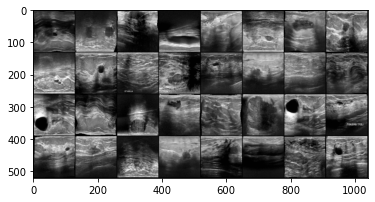

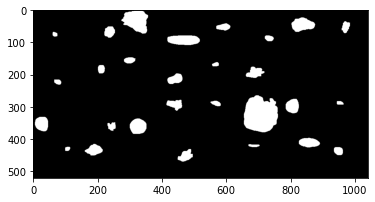

In [146]:
import torchvision
def imshow(img):
    # img = np.clip(img, 0, 1)
    plt.imshow(np.transpose(img.numpy(), (1, 2, 0)))
    plt.show()

##################
#### set seed ####
##################
# set_seeds()

image_iter = iter(train_loader)
images, masks = image_iter.next()
imshow(torchvision.utils.make_grid(images[:8*4]))
imshow(torchvision.utils.make_grid(masks[:8*4].float()))

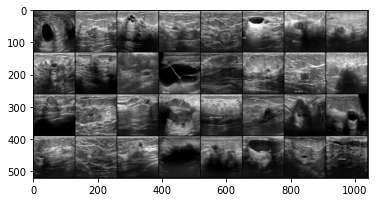

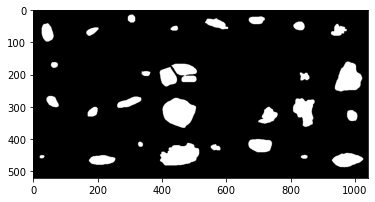

In [147]:
image_iter = iter(test_loader)
images, masks = image_iter.next()
imshow(torchvision.utils.make_grid(images[:8*4]))
imshow(torchvision.utils.make_grid(masks[:8*4].float()))

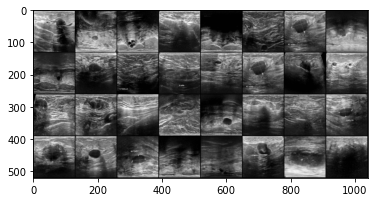

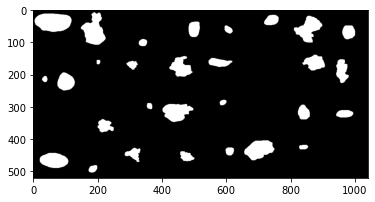

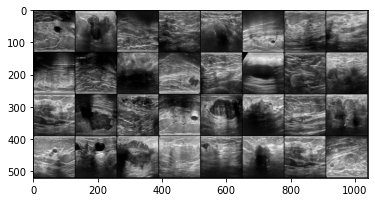

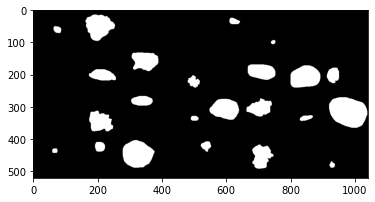

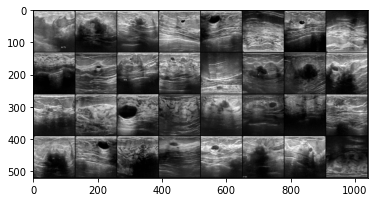

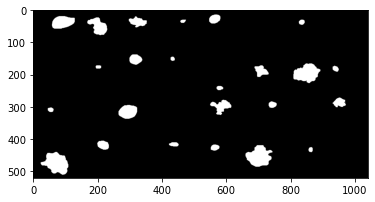

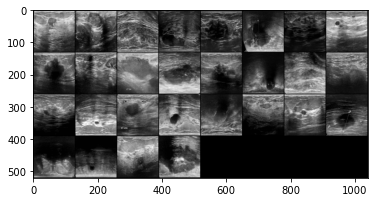

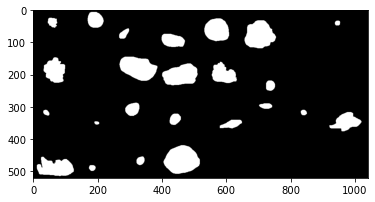

In [148]:
for i, data in enumerate(val_loader):
    images, masks = data
    
    imshow(torchvision.utils.make_grid(images))
    imshow(torchvision.utils.make_grid(masks.float()))

In [149]:
counts_list = []
for i, batch in enumerate(train_loader):
    _, target = batch
    counts_list.extend(target.numpy().flatten())
counts_list = np.array(counts_list)
counts_list

array([0., 0., 0., ..., 0., 0., 0.], dtype=float32)

In [150]:
# Calculate class weights based on class frequencies
class_weights = compute_class_weight(
           class_weight='balanced',
            classes = np.unique(counts_list), 
            y = counts_list)
# Print the class weights
print(class_weights)

[0.54538207 6.00878312]


In [151]:
device_ids = [d for d in range(torch.cuda.device_count())]
device = f'cuda:{device_ids[0]}' if torch.cuda.is_available() else "cpu"

class_weights = torch.tensor(class_weights).to(torch.float).to(device)
class_weights

tensor([0.5454, 6.0088], device='cuda:0')

In [152]:
model = UNet(num_classes=2,initial_filter_size=64*2,num_downs=4)

#loss_function = torch.nn.CrossEntropyLoss(weight=class_weights)
loss_function = torch.nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001, weight_decay=0.0000001)

step_size = 20
gamma = 0.1
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma, verbose=True)

model = model.to(device)

if device == 'cuda:0':
    model = nn.DataParallel(model, device_ids)

device, device_ids

Adjusting learning rate of group 0 to 1.0000e-04.


('cuda:0', [0, 1, 2, 3])

In [153]:
def calculate_f1_score(ground_truth, predicted):
    """
    Calculate the F1 score between the ground truth and predicted 2D images.
    
    Args:
        ground_truth (numpy.ndarray): Ground truth 2D image.
        predicted (numpy.ndarray): Predicted 2D image.
    
    Returns:
        float: The F1 score.
    """
    # Flatten the images
    ground_truth_flat = ground_truth.flatten()
    predicted_flat = predicted.flatten()

    # Calculate the F1 score
    if torch.sum(ground_truth_flat)+torch.sum(predicted_flat) > 0:
        f1 = f1_score(ground_truth_flat, predicted_flat, zero_division=0)
    else:
        f1 = 1.

    return f1

In [154]:
f1_list = [0.]
loss_list = []

def train(epoch, model):
    """
    This method is executed once per epoch and takes 
    care of model weight update cycle
    """
    global val_loss_list, val_dc_list, val_jc_list
    
    print(f"\nTraining epoch {epoch}...")
    model.train()

    # Loop over our minibatches
    for i, batch in enumerate(train_loader):
        optimizer.zero_grad()

        data, target = batch
        data = data.to('cuda')
        target = target.long().to('cuda')

        # prediction
        prediction = model(data)

        prediction_softmax = F.softmax(prediction, dim=1)
        loss = loss_function(prediction, target[:, 0, :, :])

        loss.backward()
        optimizer.step()

        if (i % 2) == 0:
            # Output to console on every 10th batch
            print(f"\nEpoch: {epoch} Train loss: {loss}, {100*(i+1)/len(train_loader):.1f}% complete")

            counter = 100*epoch + 100*(i/len(train_loader))

        print(".", end='')

    print("\nTraining complete")
    
    print(f"\nValidating epoch {epoch}...")

    # Turn off gradient accumulation by switching model to "eval" mode
   
    model.eval()
    
    with torch.no_grad():
        
        for i, batch in enumerate(val_loader):
            
            data, target = batch
            data = data.to('cuda')
            target = target.long().to('cuda')
            
            prediction = model(data)
            prediction_softmax = F.softmax(prediction, dim=1)
            prediction_argmax = torch.argmax(prediction, dim=1)

            ground_truth = target[:, 0, :, :].cpu()
            predicted = prediction_argmax.cpu()
            
            f1_score = calculate_f1_score(ground_truth, predicted)
            loss = loss_function(prediction, target[:, 0, :, :])
            
            if max(f1_list) < f1_score:
                torch.save({
                    'model_state_dict': model.state_dict(),
                    'optimizer_state_dict': optimizer.state_dict()
                }, 'unet_pretrained.pth')
                print(f"F1 has improved from {max(f1_list)} to {f1_score}")
            else:
                print("No improvement on F1")
                
            f1_list.append(f1_score)
            print(f"Batch {i} | Loss {loss} | Current F1 {f1_score} | Max F1 {max(f1_list)}")
            loss_list.append(loss.item())
            
    scheduler.step()

In [155]:
for i in range(100):
    epoch = i+1
    train(epoch, model)


Training epoch 1...

Epoch: 1 Train loss: 0.6987518072128296, 6.7% complete
..
Epoch: 1 Train loss: 0.6018708348274231, 20.0% complete
..
Epoch: 1 Train loss: 0.5107381343841553, 33.3% complete
..
Epoch: 1 Train loss: 0.3700847923755646, 46.7% complete
..
Epoch: 1 Train loss: 0.23856160044670105, 60.0% complete
..
Epoch: 1 Train loss: 0.3271661698818207, 73.3% complete
..
Epoch: 1 Train loss: 0.29240649938583374, 86.7% complete
..
Epoch: 1 Train loss: 0.3185926079750061, 100.0% complete
.
Training complete

Validating epoch 1...
No improvement on F1
Batch 0 | Loss 0.32000967860221863 | Current F1 0.0 | Max F1 0.0
No improvement on F1
Batch 1 | Loss 0.33255913853645325 | Current F1 0.0 | Max F1 0.0
No improvement on F1
Batch 2 | Loss 0.29856809973716736 | Current F1 0.0 | Max F1 0.0
No improvement on F1
Batch 3 | Loss 0.24618783593177795 | Current F1 0.0 | Max F1 0.0
No improvement on F1
Batch 4 | Loss 0.3457140326499939 | Current F1 0.0 | Max F1 0.0
Adjusting learning rate of group 0 

..
Epoch: 8 Train loss: 0.14716485142707825, 73.3% complete
..
Epoch: 8 Train loss: 0.137486070394516, 86.7% complete
..
Epoch: 8 Train loss: 0.11980108916759491, 100.0% complete
.
Training complete

Validating epoch 8...
No improvement on F1
Batch 0 | Loss 0.2015211582183838 | Current F1 0.46358774914924644 | Max F1 0.6434087030716723
F1 has improved from 0.6434087030716723 to 0.6609255871926446
Batch 1 | Loss 0.11472593992948532 | Current F1 0.6609255871926446 | Max F1 0.6609255871926446
No improvement on F1
Batch 2 | Loss 0.14477641880512238 | Current F1 0.5740376564964271 | Max F1 0.6609255871926446
No improvement on F1
Batch 3 | Loss 0.19700293242931366 | Current F1 0.3902006840565377 | Max F1 0.6609255871926446
No improvement on F1
Batch 4 | Loss 0.307224839925766 | Current F1 0.5149400676747787 | Max F1 0.6609255871926446
Adjusting learning rate of group 0 to 1.0000e-04.

Training epoch 9...

Epoch: 9 Train loss: 0.19327054917812347, 6.7% complete
..
Epoch: 9 Train loss: 0.10515

..
Epoch: 15 Train loss: 0.08806099742650986, 46.7% complete
..
Epoch: 15 Train loss: 0.11832542717456818, 60.0% complete
..
Epoch: 15 Train loss: 0.16091305017471313, 73.3% complete
..
Epoch: 15 Train loss: 0.13832001388072968, 86.7% complete
..
Epoch: 15 Train loss: 0.11381059885025024, 100.0% complete
.
Training complete

Validating epoch 15...
No improvement on F1
Batch 0 | Loss 0.13540366291999817 | Current F1 0.7085493230174083 | Max F1 0.7108530745433741
No improvement on F1
Batch 1 | Loss 0.1917947679758072 | Current F1 0.6108786610878661 | Max F1 0.7108530745433741
No improvement on F1
Batch 2 | Loss 0.1341259926557541 | Current F1 0.6664637174947527 | Max F1 0.7108530745433741
No improvement on F1
Batch 3 | Loss 0.12542004883289337 | Current F1 0.6035875106992669 | Max F1 0.7108530745433741
No improvement on F1
Batch 4 | Loss 0.1524229794740677 | Current F1 0.7028914130394125 | Max F1 0.7108530745433741
Adjusting learning rate of group 0 to 1.0000e-04.

Training epoch 16...



..
Epoch: 22 Train loss: 0.11201130598783493, 20.0% complete
..
Epoch: 22 Train loss: 0.11384804546833038, 33.3% complete
..
Epoch: 22 Train loss: 0.09501822292804718, 46.7% complete
..
Epoch: 22 Train loss: 0.11248700320720673, 60.0% complete
..
Epoch: 22 Train loss: 0.08532135933637619, 73.3% complete
..
Epoch: 22 Train loss: 0.09711872041225433, 86.7% complete
..
Epoch: 22 Train loss: 0.08165038377046585, 100.0% complete
.
Training complete

Validating epoch 22...
No improvement on F1
Batch 0 | Loss 0.20764513313770294 | Current F1 0.6909619682784744 | Max F1 0.7692221787927856
No improvement on F1
Batch 1 | Loss 0.10753976553678513 | Current F1 0.7192949120832541 | Max F1 0.7692221787927856
No improvement on F1
Batch 2 | Loss 0.1565576046705246 | Current F1 0.6468226744924663 | Max F1 0.7692221787927856
No improvement on F1
Batch 3 | Loss 0.144053116440773 | Current F1 0.6748490709805991 | Max F1 0.7692221787927856
F1 has improved from 0.7692221787927856 to 0.856195189719545
Batch 


Epoch: 29 Train loss: 0.11418064683675766, 6.7% complete
..
Epoch: 29 Train loss: 0.08970515429973602, 20.0% complete
..
Epoch: 29 Train loss: 0.06866403669118881, 33.3% complete
..
Epoch: 29 Train loss: 0.07756500691175461, 46.7% complete
..
Epoch: 29 Train loss: 0.08386775106191635, 60.0% complete
..
Epoch: 29 Train loss: 0.10145160555839539, 73.3% complete
..
Epoch: 29 Train loss: 0.09556904435157776, 86.7% complete
..
Epoch: 29 Train loss: 0.08652155846357346, 100.0% complete
.
Training complete

Validating epoch 29...
No improvement on F1
Batch 0 | Loss 0.24559466540813446 | Current F1 0.567172142956236 | Max F1 0.856195189719545
No improvement on F1
Batch 1 | Loss 0.09998786449432373 | Current F1 0.7901595065153119 | Max F1 0.856195189719545
No improvement on F1
Batch 2 | Loss 0.0647381916642189 | Current F1 0.7783213850669968 | Max F1 0.856195189719545
No improvement on F1
Batch 3 | Loss 0.12886257469654083 | Current F1 0.7529983554871216 | Max F1 0.856195189719545
No improveme


Epoch: 36 Train loss: 0.12133867293596268, 6.7% complete
..
Epoch: 36 Train loss: 0.10617711395025253, 20.0% complete
..
Epoch: 36 Train loss: 0.07941003143787384, 33.3% complete
..
Epoch: 36 Train loss: 0.059710439294576645, 46.7% complete
..
Epoch: 36 Train loss: 0.09235211461782455, 60.0% complete
..
Epoch: 36 Train loss: 0.0913454219698906, 73.3% complete
..
Epoch: 36 Train loss: 0.07803711295127869, 86.7% complete
..
Epoch: 36 Train loss: 0.07331960648298264, 100.0% complete
.
Training complete

Validating epoch 36...
No improvement on F1
Batch 0 | Loss 0.1430191844701767 | Current F1 0.7085996433959677 | Max F1 0.856195189719545
No improvement on F1
Batch 1 | Loss 0.15426665544509888 | Current F1 0.7324927363480594 | Max F1 0.856195189719545
No improvement on F1
Batch 2 | Loss 0.17658093571662903 | Current F1 0.6419352305154855 | Max F1 0.856195189719545
No improvement on F1
Batch 3 | Loss 0.09898101538419724 | Current F1 0.7465422746868667 | Max F1 0.856195189719545
No improvem


Epoch: 43 Train loss: 0.06369294971227646, 6.7% complete
..
Epoch: 43 Train loss: 0.06780138611793518, 20.0% complete
..
Epoch: 43 Train loss: 0.07929086685180664, 33.3% complete
..
Epoch: 43 Train loss: 0.06618471443653107, 46.7% complete
..
Epoch: 43 Train loss: 0.09604040533304214, 60.0% complete
..
Epoch: 43 Train loss: 0.0902736485004425, 73.3% complete
..
Epoch: 43 Train loss: 0.07364955544471741, 86.7% complete
..
Epoch: 43 Train loss: 0.07811859995126724, 100.0% complete
.
Training complete

Validating epoch 43...
No improvement on F1
Batch 0 | Loss 0.09643302857875824 | Current F1 0.7706414628252288 | Max F1 0.856195189719545
No improvement on F1
Batch 1 | Loss 0.1972467601299286 | Current F1 0.6672791303016383 | Max F1 0.856195189719545
No improvement on F1
Batch 2 | Loss 0.055350180715322495 | Current F1 0.7988458689125434 | Max F1 0.856195189719545
No improvement on F1
Batch 3 | Loss 0.22766846418380737 | Current F1 0.547286317842054 | Max F1 0.856195189719545
No improveme


Epoch: 50 Train loss: 0.09310168772935867, 6.7% complete
..
Epoch: 50 Train loss: 0.0681157112121582, 20.0% complete
..
Epoch: 50 Train loss: 0.08275757730007172, 33.3% complete
..
Epoch: 50 Train loss: 0.0778399184346199, 46.7% complete
..
Epoch: 50 Train loss: 0.05708317831158638, 60.0% complete
..
Epoch: 50 Train loss: 0.07428186386823654, 73.3% complete
..
Epoch: 50 Train loss: 0.10642238706350327, 86.7% complete
..
Epoch: 50 Train loss: 0.08820100128650665, 100.0% complete
.
Training complete

Validating epoch 50...
No improvement on F1
Batch 0 | Loss 0.09493786841630936 | Current F1 0.7265207369505158 | Max F1 0.856195189719545
No improvement on F1
Batch 1 | Loss 0.20783387124538422 | Current F1 0.6155653981740938 | Max F1 0.856195189719545
No improvement on F1
Batch 2 | Loss 0.11674828827381134 | Current F1 0.7887750594273933 | Max F1 0.856195189719545
No improvement on F1
Batch 3 | Loss 0.11303986608982086 | Current F1 0.7669484729763787 | Max F1 0.856195189719545
No improveme


Epoch: 57 Train loss: 0.061429910361766815, 6.7% complete
..
Epoch: 57 Train loss: 0.09799926728010178, 20.0% complete
..
Epoch: 57 Train loss: 0.06136860325932503, 33.3% complete
..
Epoch: 57 Train loss: 0.057508647441864014, 46.7% complete
..
Epoch: 57 Train loss: 0.08816320449113846, 60.0% complete
..
Epoch: 57 Train loss: 0.06348057836294174, 73.3% complete
..
Epoch: 57 Train loss: 0.0442424900829792, 86.7% complete
..
Epoch: 57 Train loss: 0.12393112480640411, 100.0% complete
.
Training complete

Validating epoch 57...
No improvement on F1
Batch 0 | Loss 0.2299211174249649 | Current F1 0.643851052784847 | Max F1 0.856195189719545
No improvement on F1
Batch 1 | Loss 0.1240333840250969 | Current F1 0.7816886690584836 | Max F1 0.856195189719545
No improvement on F1
Batch 2 | Loss 0.09781615436077118 | Current F1 0.721239201668156 | Max F1 0.856195189719545
No improvement on F1
Batch 3 | Loss 0.060181163251399994 | Current F1 0.7838131761204282 | Max F1 0.856195189719545
No improveme


Epoch: 64 Train loss: 0.07940671592950821, 6.7% complete
..
Epoch: 64 Train loss: 0.09161677211523056, 20.0% complete
..
Epoch: 64 Train loss: 0.05570215731859207, 33.3% complete
..
Epoch: 64 Train loss: 0.06423303484916687, 46.7% complete
..
Epoch: 64 Train loss: 0.06519988924264908, 60.0% complete
..
Epoch: 64 Train loss: 0.06045158952474594, 73.3% complete
..
Epoch: 64 Train loss: 0.11410755664110184, 86.7% complete
..
Epoch: 64 Train loss: 0.06592722237110138, 100.0% complete
.
Training complete

Validating epoch 64...
No improvement on F1
Batch 0 | Loss 0.13575240969657898 | Current F1 0.7703467582091992 | Max F1 0.856195189719545
No improvement on F1
Batch 1 | Loss 0.10287361592054367 | Current F1 0.7404133958321567 | Max F1 0.856195189719545
No improvement on F1
Batch 2 | Loss 0.15846142172813416 | Current F1 0.6641928388670267 | Max F1 0.856195189719545
No improvement on F1
Batch 3 | Loss 0.12211041152477264 | Current F1 0.7319598986449267 | Max F1 0.856195189719545
No improve


Epoch: 71 Train loss: 0.06213403865695, 6.7% complete
..
Epoch: 71 Train loss: 0.06892556697130203, 20.0% complete
..
Epoch: 71 Train loss: 0.0645458921790123, 33.3% complete
..
Epoch: 71 Train loss: 0.0601252056658268, 46.7% complete
..
Epoch: 71 Train loss: 0.08003813773393631, 60.0% complete
..
Epoch: 71 Train loss: 0.06684727966785431, 73.3% complete
..
Epoch: 71 Train loss: 0.058544788509607315, 86.7% complete
..
Epoch: 71 Train loss: 0.07055734097957611, 100.0% complete
.
Training complete

Validating epoch 71...
No improvement on F1
Batch 0 | Loss 0.09144839644432068 | Current F1 0.6654118206494818 | Max F1 0.856195189719545
No improvement on F1
Batch 1 | Loss 0.12830322980880737 | Current F1 0.7446519241974419 | Max F1 0.856195189719545
No improvement on F1
Batch 2 | Loss 0.18410524725914001 | Current F1 0.7456088594381155 | Max F1 0.856195189719545
No improvement on F1
Batch 3 | Loss 0.17674025893211365 | Current F1 0.5982527664531159 | Max F1 0.856195189719545
No improvement


Epoch: 78 Train loss: 0.08063052594661713, 6.7% complete
..
Epoch: 78 Train loss: 0.05407880246639252, 20.0% complete
..
Epoch: 78 Train loss: 0.05964253470301628, 33.3% complete
..
Epoch: 78 Train loss: 0.04631331190466881, 46.7% complete
..
Epoch: 78 Train loss: 0.07180094718933105, 60.0% complete
..
Epoch: 78 Train loss: 0.06353979557752609, 73.3% complete
..
Epoch: 78 Train loss: 0.0631512999534607, 86.7% complete
..
Epoch: 78 Train loss: 0.05595195293426514, 100.0% complete
.
Training complete

Validating epoch 78...
No improvement on F1
Batch 0 | Loss 0.12218251824378967 | Current F1 0.7484946961800233 | Max F1 0.8674672248540266
No improvement on F1
Batch 1 | Loss 0.2844058573246002 | Current F1 0.6133609758061269 | Max F1 0.8674672248540266
No improvement on F1
Batch 2 | Loss 0.088969886302948 | Current F1 0.7139064798823004 | Max F1 0.8674672248540266
No improvement on F1
Batch 3 | Loss 0.0925997719168663 | Current F1 0.7725473059759795 | Max F1 0.8674672248540266
No improvem


Epoch: 85 Train loss: 0.10870694369077682, 6.7% complete
..
Epoch: 85 Train loss: 0.05692114681005478, 20.0% complete
..
Epoch: 85 Train loss: 0.05909870192408562, 33.3% complete
..
Epoch: 85 Train loss: 0.05410772189497948, 46.7% complete
..
Epoch: 85 Train loss: 0.061987265944480896, 60.0% complete
..
Epoch: 85 Train loss: 0.06817764043807983, 73.3% complete
..
Epoch: 85 Train loss: 0.07907916605472565, 86.7% complete
..
Epoch: 85 Train loss: 0.09250978380441666, 100.0% complete
.
Training complete

Validating epoch 85...
No improvement on F1
Batch 0 | Loss 0.10798324644565582 | Current F1 0.8045585361862686 | Max F1 0.8674672248540266
No improvement on F1
Batch 1 | Loss 0.12835179269313812 | Current F1 0.7153166029117098 | Max F1 0.8674672248540266
No improvement on F1
Batch 2 | Loss 0.17842450737953186 | Current F1 0.6272904084348451 | Max F1 0.8674672248540266
No improvement on F1
Batch 3 | Loss 0.14326238632202148 | Current F1 0.6903073286052009 | Max F1 0.8674672248540266
No im


Epoch: 92 Train loss: 0.06013598293066025, 6.7% complete
..
Epoch: 92 Train loss: 0.08722992986440659, 20.0% complete
..
Epoch: 92 Train loss: 0.04255559667944908, 33.3% complete
..
Epoch: 92 Train loss: 0.11388944089412689, 46.7% complete
..
Epoch: 92 Train loss: 0.07390959560871124, 60.0% complete
..
Epoch: 92 Train loss: 0.05692135542631149, 73.3% complete
..
Epoch: 92 Train loss: 0.048447463661432266, 86.7% complete
..
Epoch: 92 Train loss: 0.09586214274168015, 100.0% complete
.
Training complete

Validating epoch 92...
No improvement on F1
Batch 0 | Loss 0.200958713889122 | Current F1 0.6246611147413349 | Max F1 0.8674672248540266
No improvement on F1
Batch 1 | Loss 0.12494567781686783 | Current F1 0.7336297846368471 | Max F1 0.8674672248540266
No improvement on F1
Batch 2 | Loss 0.1053931787610054 | Current F1 0.6813511830635118 | Max F1 0.8674672248540266
No improvement on F1
Batch 3 | Loss 0.19104553759098053 | Current F1 0.751417019170612 | Max F1 0.8674672248540266
No improv


Epoch: 99 Train loss: 0.07434184849262238, 6.7% complete
..
Epoch: 99 Train loss: 0.10745073109865189, 20.0% complete
..
Epoch: 99 Train loss: 0.05989928916096687, 33.3% complete
..
Epoch: 99 Train loss: 0.08583763986825943, 46.7% complete
..
Epoch: 99 Train loss: 0.08534296602010727, 60.0% complete
..
Epoch: 99 Train loss: 0.08556276559829712, 73.3% complete
..
Epoch: 99 Train loss: 0.059382520616054535, 86.7% complete
..
Epoch: 99 Train loss: 0.1093331128358841, 100.0% complete
.
Training complete

Validating epoch 99...
No improvement on F1
Batch 0 | Loss 0.11900289356708527 | Current F1 0.7297219096608263 | Max F1 0.8674672248540266
No improvement on F1
Batch 1 | Loss 0.1281745433807373 | Current F1 0.7319563649896494 | Max F1 0.8674672248540266
No improvement on F1
Batch 2 | Loss 0.15302112698554993 | Current F1 0.6866515578142527 | Max F1 0.8674672248540266
No improvement on F1
Batch 3 | Loss 0.18385036289691925 | Current F1 0.7424857403400862 | Max F1 0.8674672248540266
No impr

In [ ]:
# Validating epoch 73... Max F1 0.8738904062820075

In [110]:
checkpoint = torch.load('unet_pretrained.pth')
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

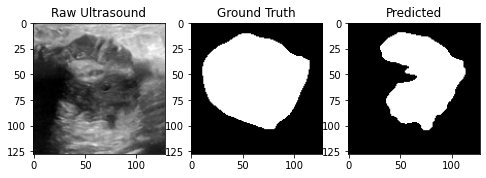

F1 score: 0.8076759061833689


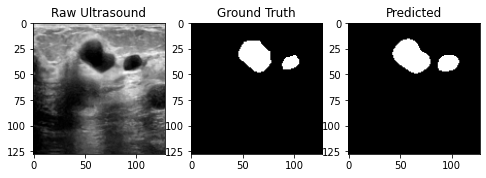

F1 score: 0.8632004038364464


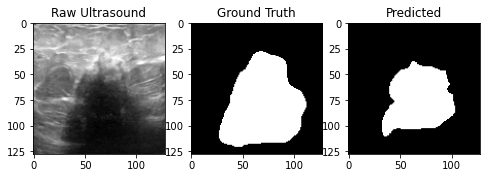

F1 score: 0.7760925738681047


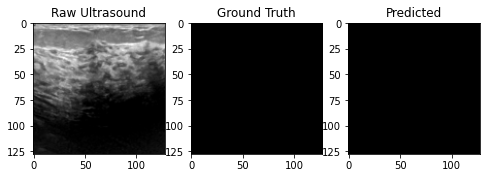

F1 score: 1.0


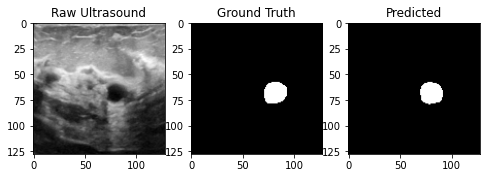

F1 score: 0.937984496124031


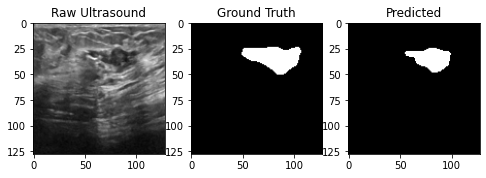

F1 score: 0.7887154861944777


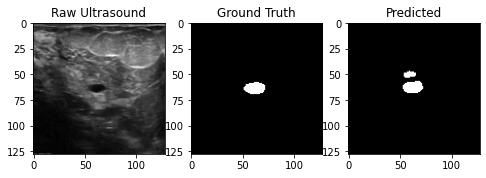

F1 score: 0.7577092511013216


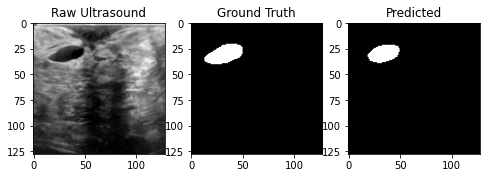

F1 score: 0.8848614072494669


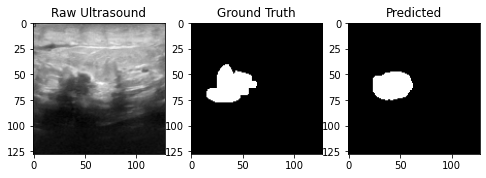

F1 score: 0.810755961440893


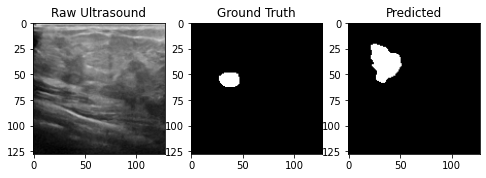

F1 score: 0.24217961654894046


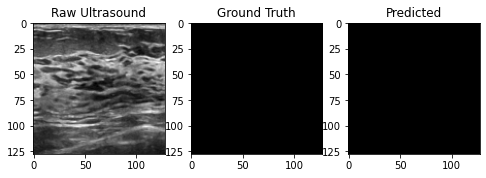

F1 score: 1.0


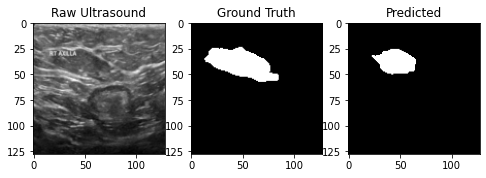

F1 score: 0.6801470588235294


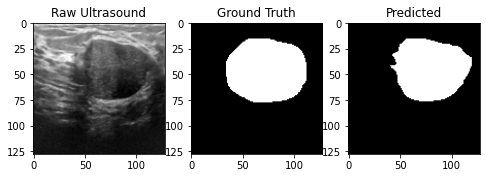

F1 score: 0.8921298121140454


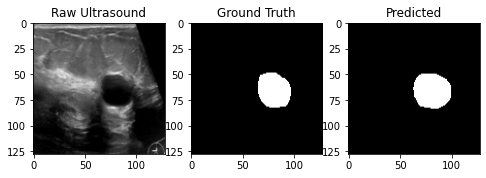

F1 score: 0.9158878504672898


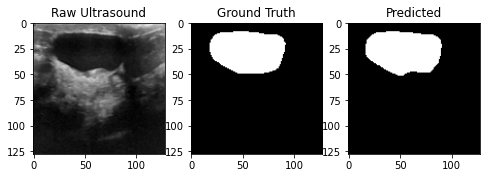

F1 score: 0.9755321265168092


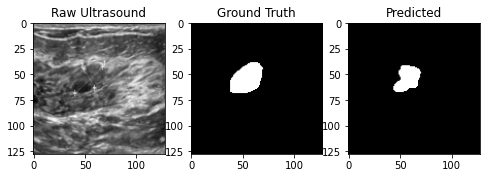

F1 score: 0.7684563758389263


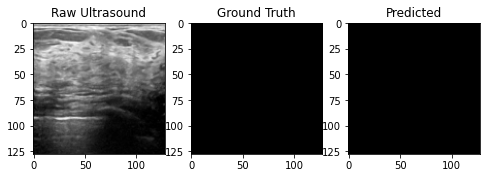

F1 score: 1.0


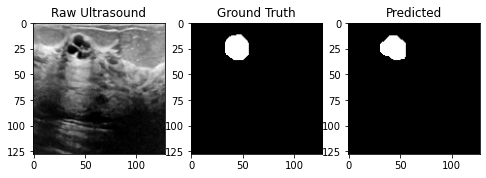

F1 score: 0.9329073482428115


F1 score: 1.0


F1 score: 0.6356340288924559


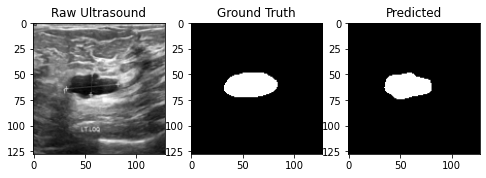

F1 score: 0.9006831318970048


F1 score: 0.6789915966386554


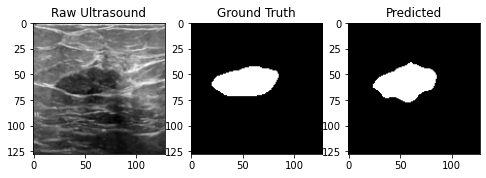

F1 score: 0.8948439620081411


F1 score: 0.0


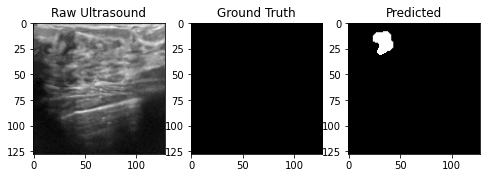

F1 score: 0.0


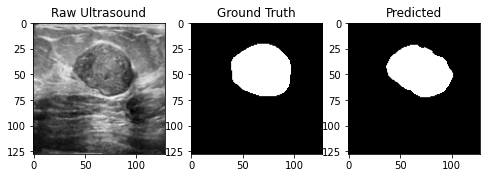

F1 score: 0.9285561038403776


F1 score: 0.0


F1 score: 0.0


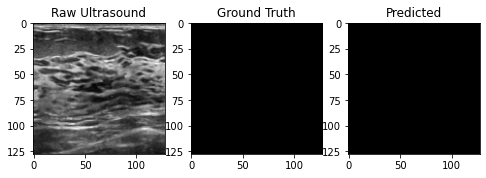

F1 score: 1.0


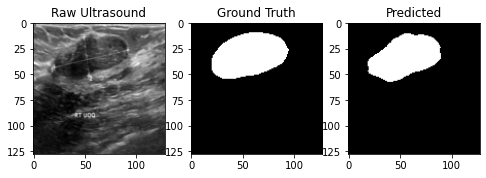

F1 score: 0.9149115417017691


F1 score: 0.8686448030539649


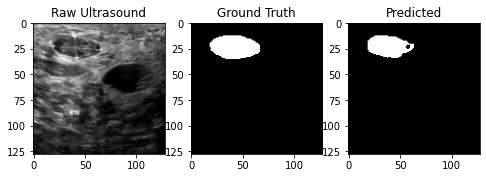

F1 score: 0.8719550281074329


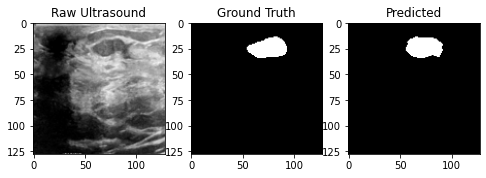

F1 score: 0.8963774220724516


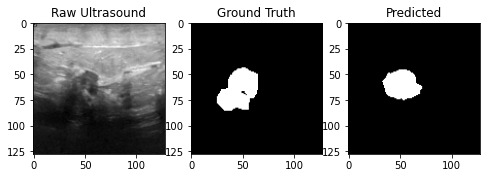

F1 score: 0.7177664974619289


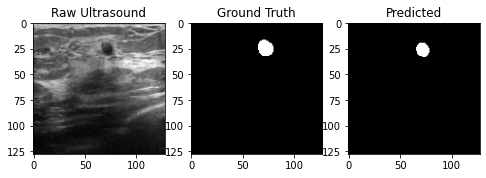

F1 score: 0.8238805970149253


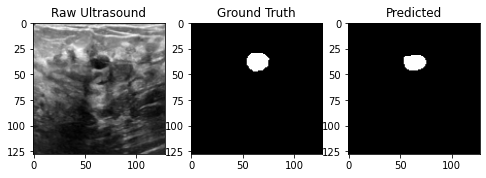

F1 score: 0.9106239460370995


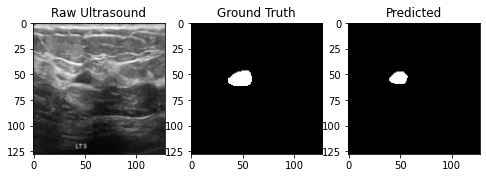

F1 score: 0.7494356659142212


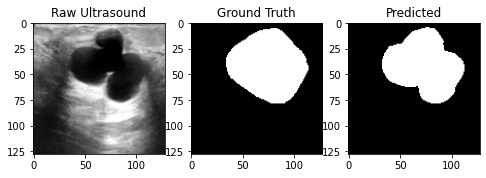

F1 score: 0.9447464913389808


F1 score: 0.6419753086419753


F1 score: 0.9269102990033223


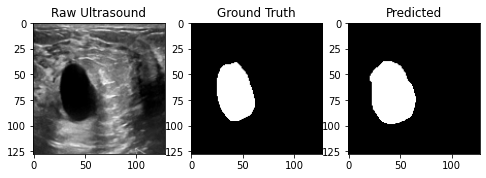

F1 score: 0.8741830065359477


F1 score: 0.8804175175856593


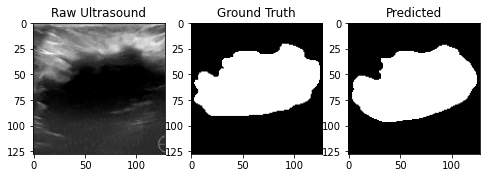

F1 score: 0.9475044419318366


F1 score: 0.0


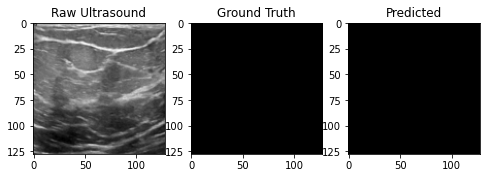

F1 score: 1.0


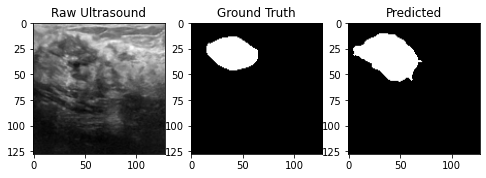

F1 score: 0.7802340702210663


F1 score: 0.7112068965517241


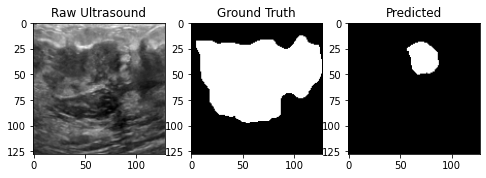

F1 score: 0.18061948003483022


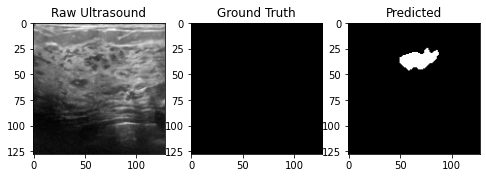

F1 score: 0.0


F1 score: 0.0374916313322919


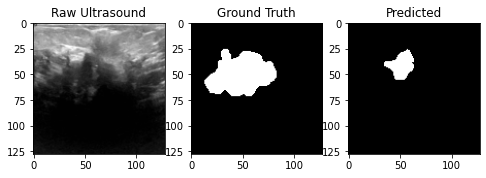

F1 score: 0.3736842105263158


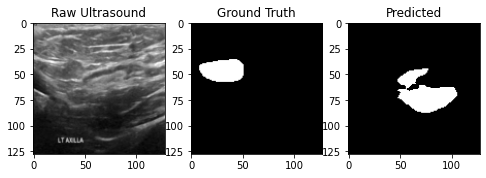

F1 score: 0.0


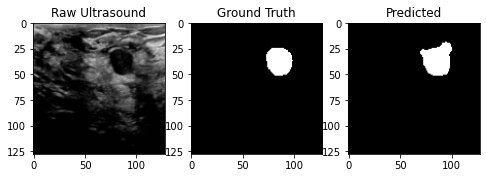

F1 score: 0.8742138364779874


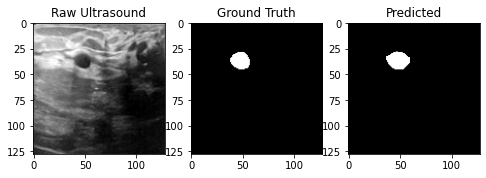

F1 score: 0.911070780399274


F1 score: 0.9728700618752975


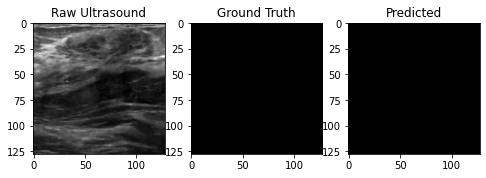

F1 score: 1.0


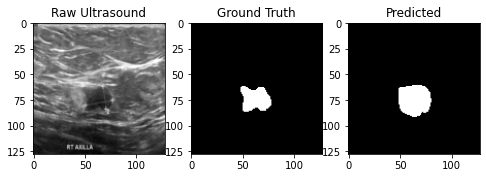

F1 score: 0.7950401167031363


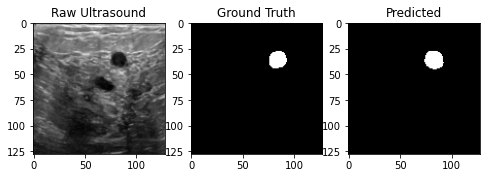

F1 score: 0.9101796407185629


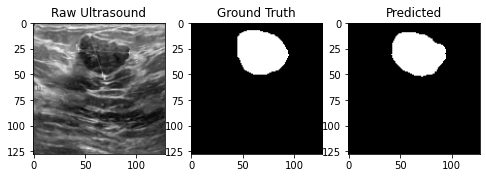

F1 score: 0.9341211225997046


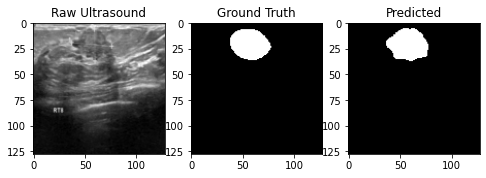

F1 score: 0.9282296650717703


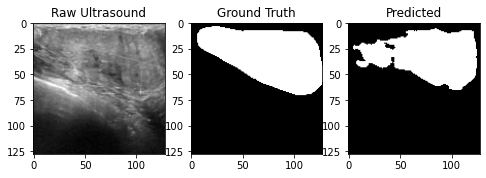

F1 score: 0.8391949583248628


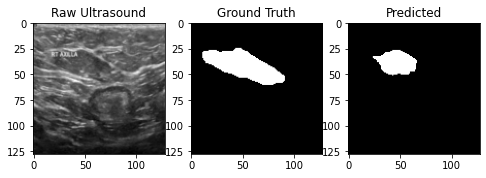

F1 score: 0.6320879120879122


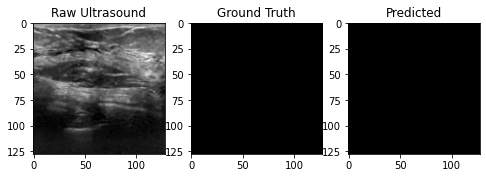

F1 score: 1.0


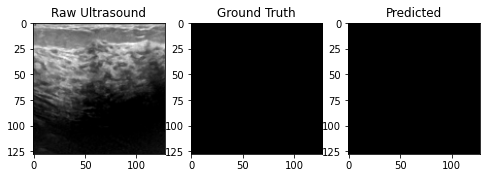

F1 score: 1.0


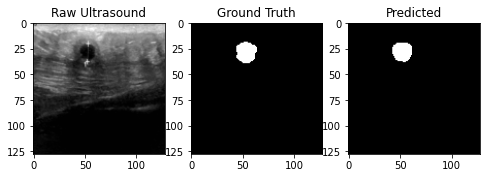

F1 score: 0.9076433121019108


F1 score: 0.7886962106615286


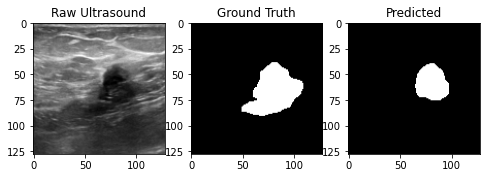

F1 score: 0.6617375231053604


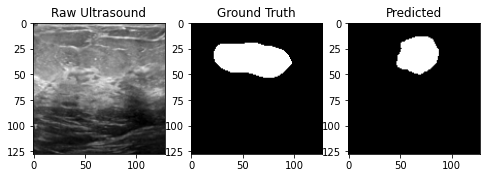

F1 score: 0.6075216972034716


F1 score: 1.0


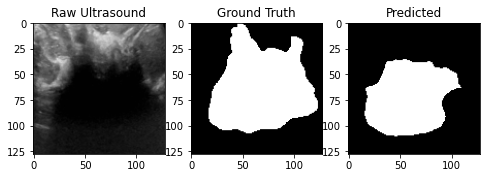

F1 score: 0.7756820205618068


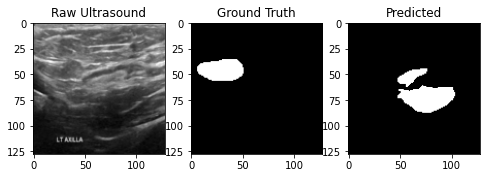

F1 score: 0.0


F1 score: 0.11491108071135431


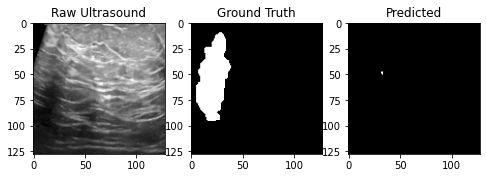

F1 score: 0.005464480874316939


F1 score: 0.8677248677248677


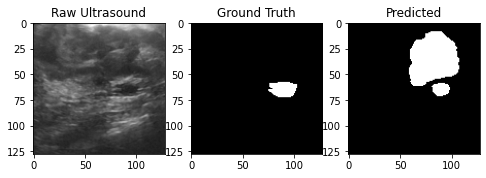

F1 score: 0.14661806399351962


F1 score: 0.9006802721088435


F1 score: 0.0


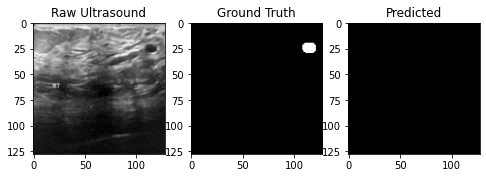

F1 score: 0.0


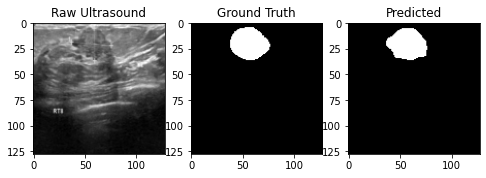

F1 score: 0.930232558139535


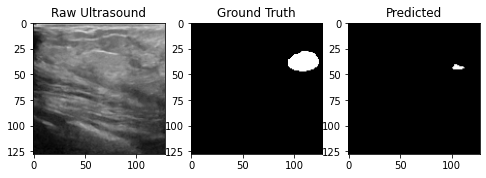

F1 score: 0.15694164989939638


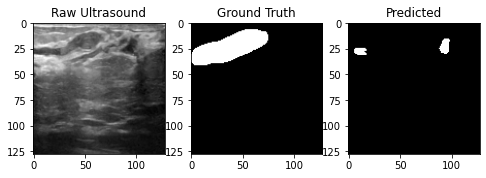

F1 score: 0.08751458576429404


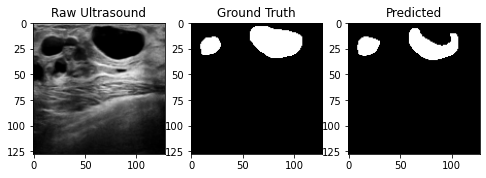

F1 score: 0.7911753518448079


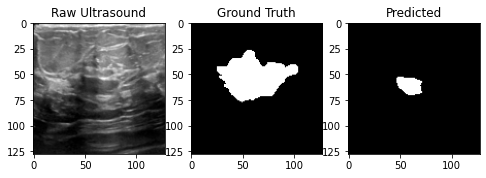

F1 score: 0.268283144309738


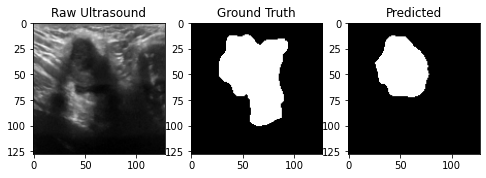

F1 score: 0.7178582879127926


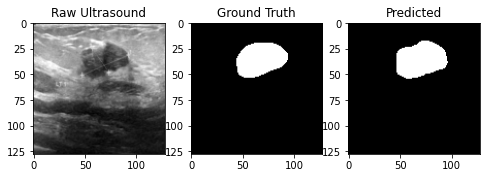

F1 score: 0.9012715033657442


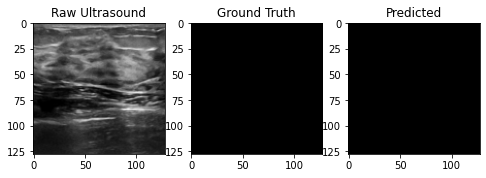

F1 score: 1.0


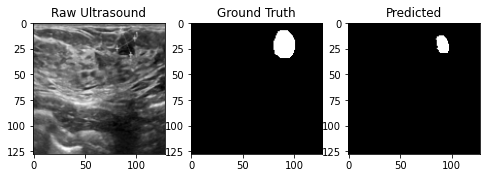

F1 score: 0.5375


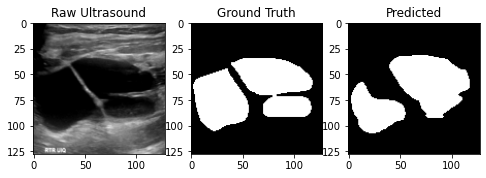

F1 score: 0.8229355945891378


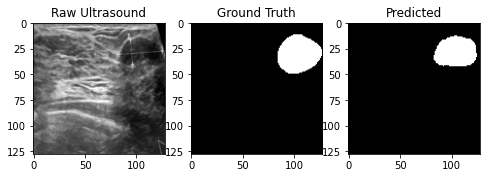

F1 score: 0.883762200532387


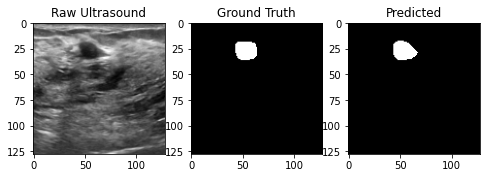

F1 score: 0.9201183431952662


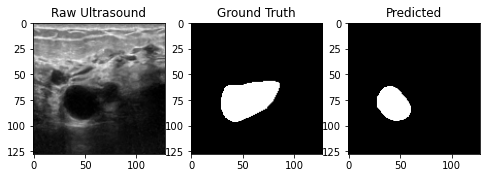

F1 score: 0.6537987679671458


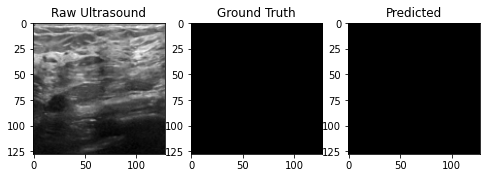

F1 score: 1.0


F1 score: 0.8764350453172205


F1 score: 1.0


F1 score: 0.0


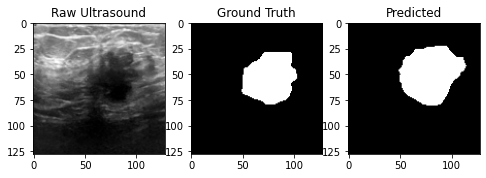

F1 score: 0.8558711318355235


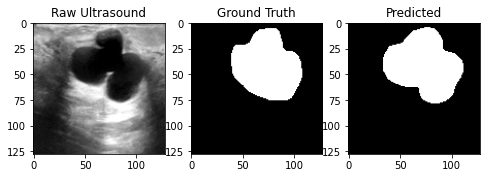

F1 score: 0.9255672385168788


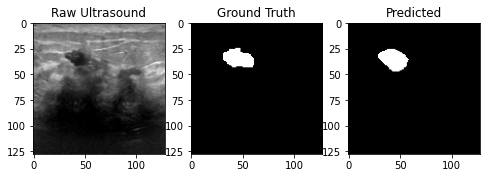

F1 score: 0.8541666666666667


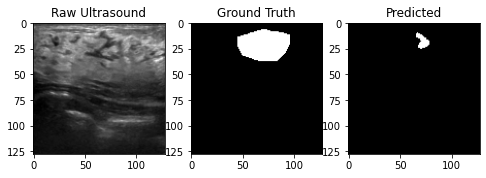

F1 score: 0.16593245227606462


F1 score: 0.9218989280245022


F1 score: 0.8919896640826874


F1 score: 0.6387774594078318


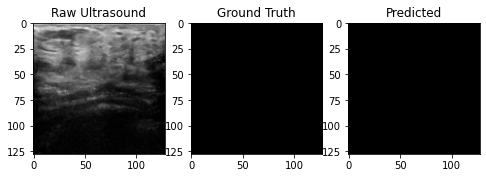

F1 score: 1.0


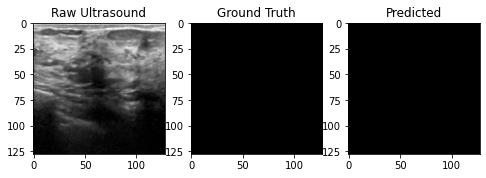

F1 score: 1.0


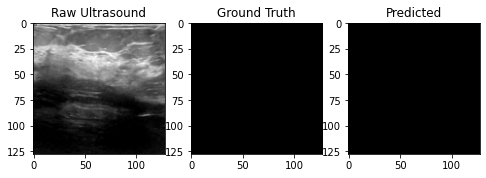

F1 score: 1.0


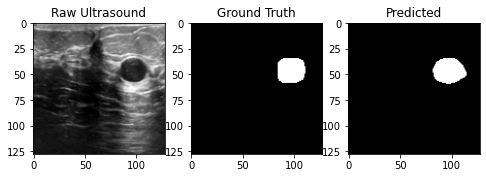

F1 score: 0.9305785123966943


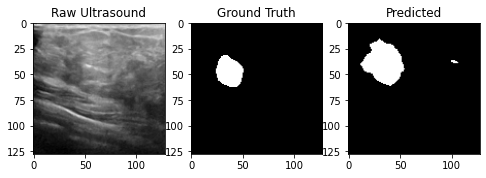

F1 score: 0.6167209554831704


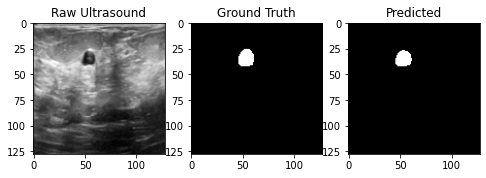

F1 score: 0.9473684210526316


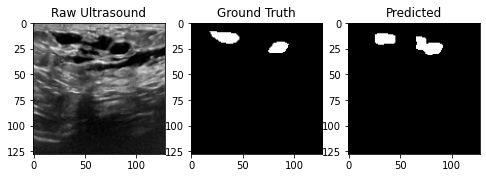

F1 score: 0.691609977324263


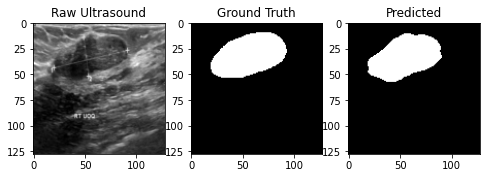

F1 score: 0.9383088869715273


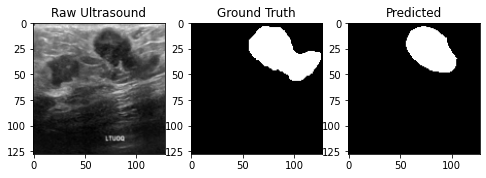

F1 score: 0.8288535381239714


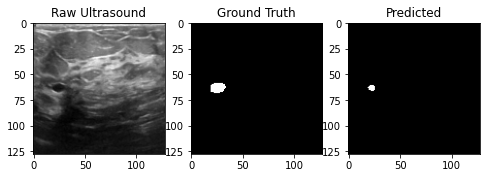

F1 score: 0.41025641025641024


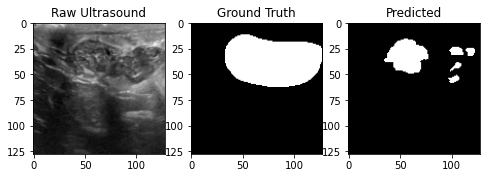

F1 score: 0.4827586206896552


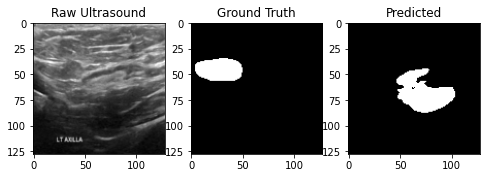

F1 score: 0.0


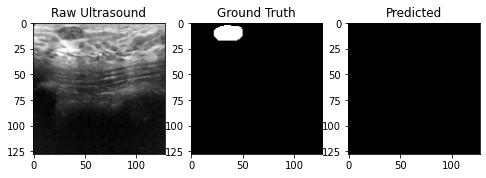

F1 score: 0.0


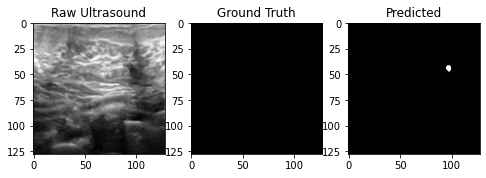

F1 score: 0.0


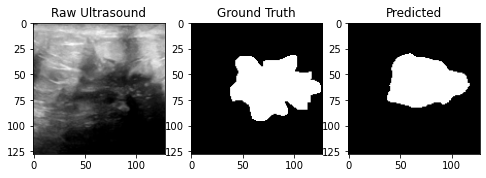

F1 score: 0.8264984227129338


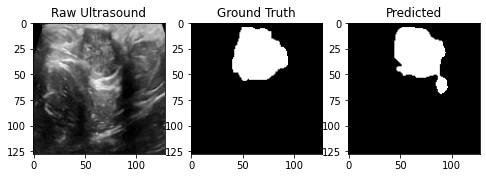

F1 score: 0.8553580009610764


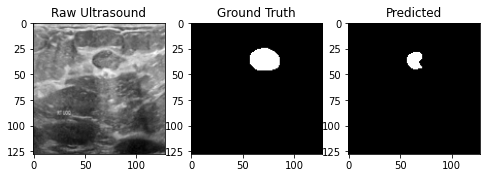

F1 score: 0.5561643835616438


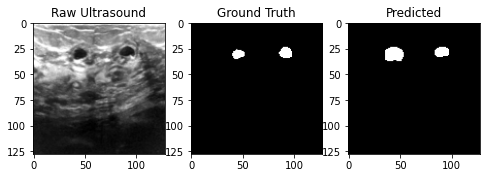

F1 score: 0.6878504672897195


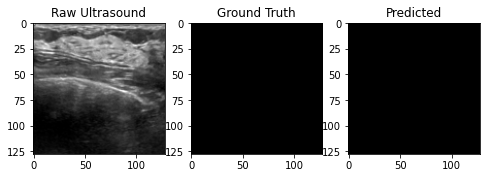

F1 score: 1.0


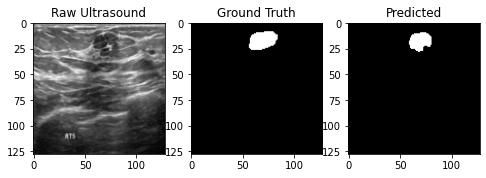

F1 score: 0.8245363766048501


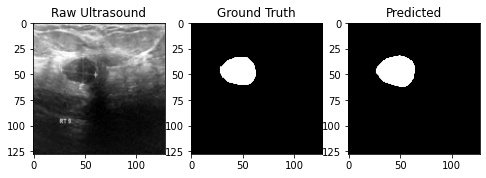

F1 score: 0.923076923076923


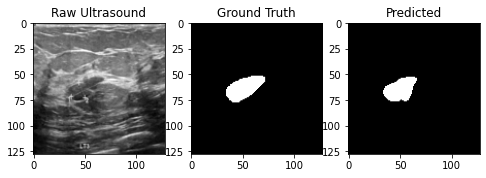

F1 score: 0.8753224419604471


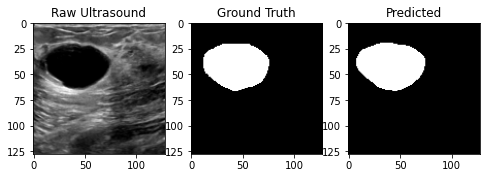

F1 score: 0.9527304122598749


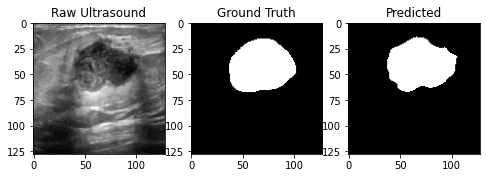

F1 score: 0.9303760848601736


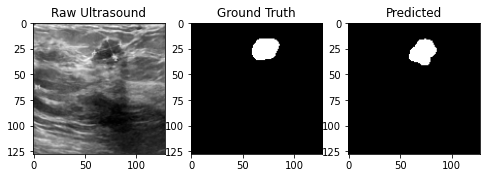

F1 score: 0.8148936170212765


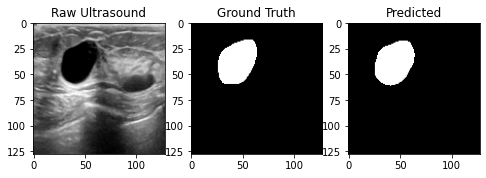

F1 score: 0.9625836943678614


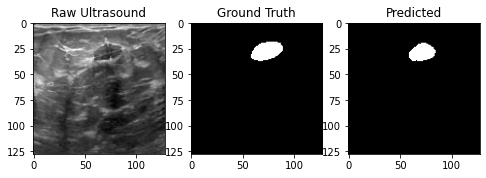

F1 score: 0.8578745198463509


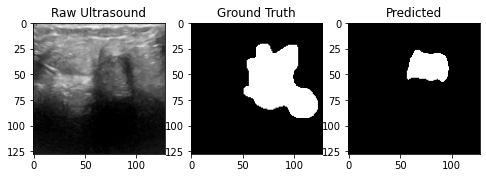

F1 score: 0.4590163934426229


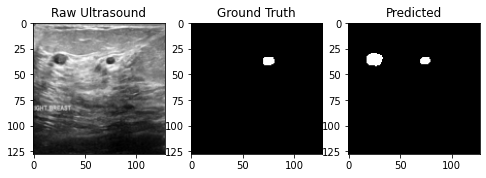

F1 score: 0.4013157894736842


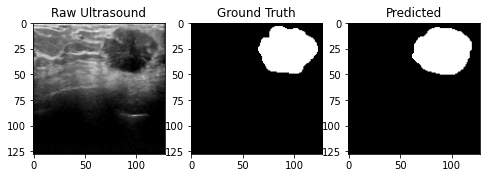

F1 score: 0.9408224674022065


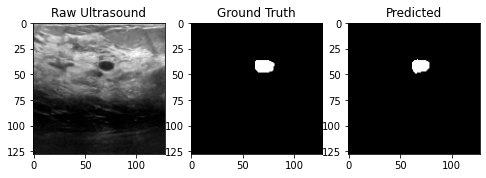

F1 score: 0.9242819843342037


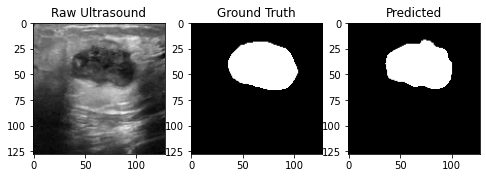

F1 score: 0.9549248747913189


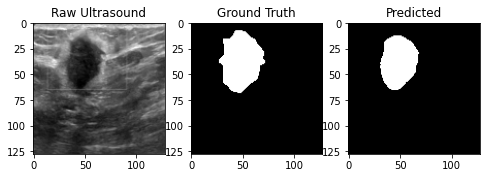

F1 score: 0.889622075584883


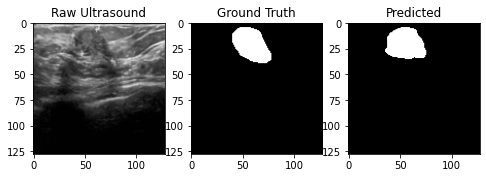

F1 score: 0.8723628691983122


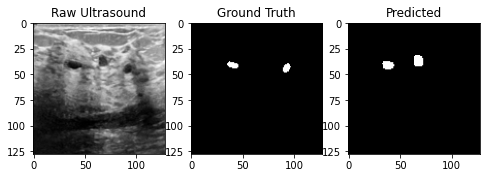

F1 score: 0.34328358208955223


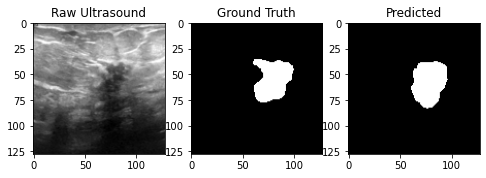

F1 score: 0.8589473684210526


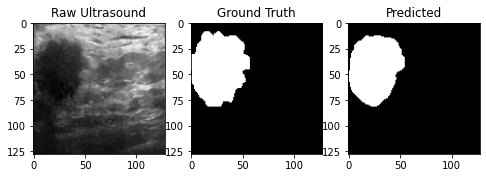

F1 score: 0.9384563073784427


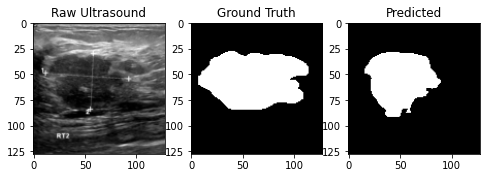

F1 score: 0.7600314712824547


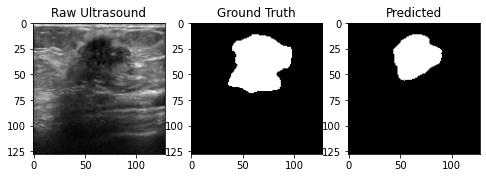

F1 score: 0.7305389221556886


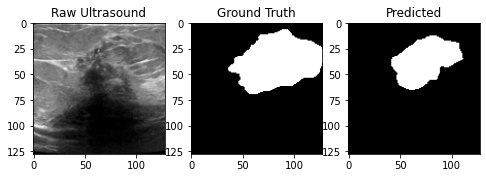

F1 score: 0.754038301415487


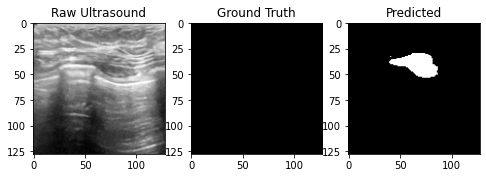

F1 score: 0.0


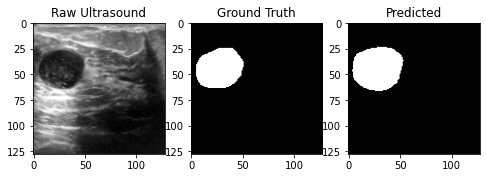

F1 score: 0.9180537772087067


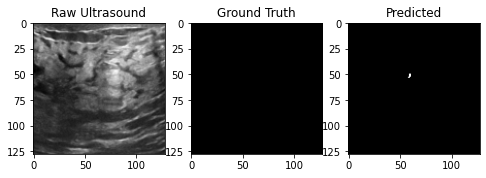

F1 score: 0.0


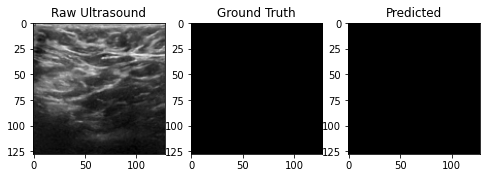

F1 score: 1.0


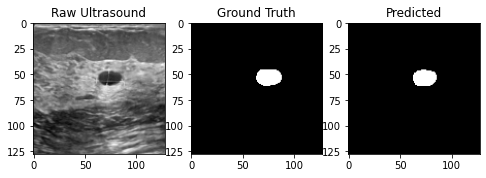

F1 score: 0.9167974882260596


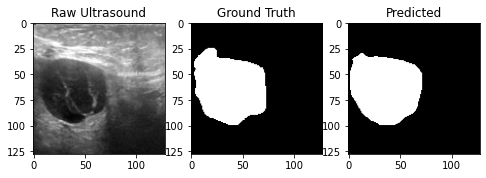

F1 score: 0.9514765187979707


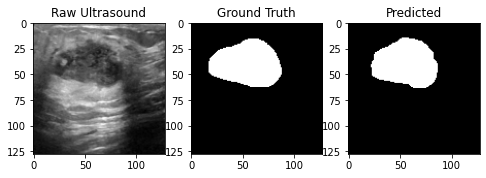

F1 score: 0.9507246376811594


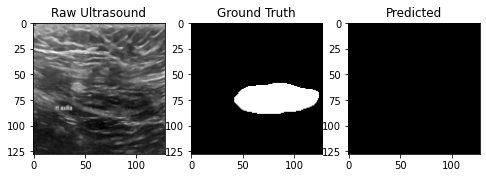

F1 score: 0.0


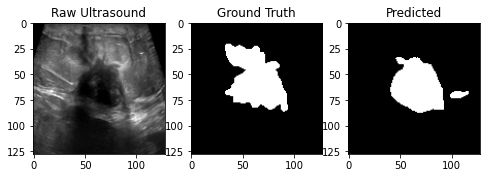

F1 score: 0.7996593570364062


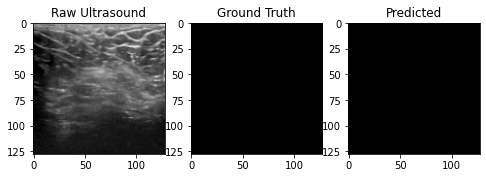

F1 score: 1.0


F1 score: 1.0


F1 score: 0.0


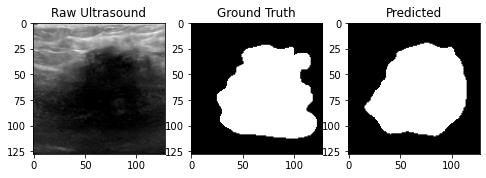

F1 score: 0.9031915700098553


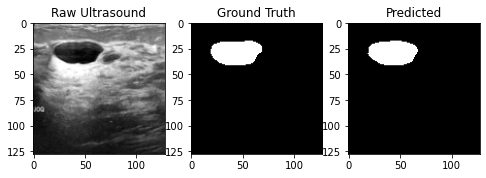

F1 score: 0.9581589958158996


In [156]:
model.eval()
g = []
p = []
f1_list = []

with torch.no_grad():

    for i, batch in enumerate(test_loader):

        data, target = batch
        data = data.to('cuda')
        target = target.long().to('cuda')

        prediction = model(data)
        prediction_softmax = F.softmax(prediction, dim=1)
        prediction_argmax = torch.argmax(prediction, dim=1)
        
        raw_ultra = data[:, 0, :, :].cpu()
        ground_truth = target[:, 0, :, :].to(torch.int64).cpu()
        predicted = prediction_argmax.cpu()
        g.append(ground_truth)
        p.append(predicted)
        
        loss = loss_function(prediction, target[:, 0, :, :])

        for i in range(ground_truth.size(0)):
            fig, ax = plt.subplots(1,3, figsize=(8,4))
            ax[0].imshow(raw_ultra[i], cmap='gray')
            ax[0].set_title('Raw Ultrasound')
            ax[1].imshow(ground_truth[i], cmap='gray')
            ax[1].set_title('Ground Truth')
            ax[2].imshow(predicted[i], cmap='gray')
            ax[2].set_title('Predicted')
            plt.show()
            f1_s = calculate_f1_score(ground_truth[i], predicted[i])
            f1_list.append(f1_s)
            print(f"F1 score: {f1_s}")

In [157]:
np.mean(f1_list), np.max(f1_list), np.median(f1_list), np.min(f1_list)

(0.7028247241565089, 1.0, 0.8584109441337018, 0.0)